INFO patool: Extracting /content/drive/MyDrive/animals.rar ...
INFO:patool:Extracting /content/drive/MyDrive/animals.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- /content/drive/MyDrive/animals.rar
INFO:patool:running /usr/bin/unrar x -kb -or -- /content/drive/MyDrive/animals.rar
INFO patool: ... /content/drive/MyDrive/animals.rar extracted to `/content/extracted_animals'.
INFO:patool:... /content/drive/MyDrive/animals.rar extracted to `/content/extracted_animals'.


Found 57 classes
- bat: 60 images
- bear: 60 images
- bee: 60 images
- butterfly: 60 images
- cat: 60 images
- caterpillar: 60 images
- chimpanzee: 60 images
- cockroach: 60 images
- cow: 60 images
- crow: 60 images
- deer: 60 images
- dog: 60 images
- dolphin: 60 images
- donkey: 60 images
- duck: 60 images
- eagle: 60 images
- elephant: 60 images
- fly: 60 images
- fox: 60 images
- goat: 60 images
- goldfish: 60 images
- goose: 60 images
- gorilla: 60 images
- grasshopper: 60 images
- hamster: 60 images
- hedgehog: 60 images
- hippopotamus: 60 images
- horse: 60 images
- hyena: 60 images
- kangaroo: 60 images
- ladybugs: 60 images
- lion: 60 images
- lizard: 60 images
- mosquito: 60 images
- octopus: 60 images
- owl: 60 images
- ox: 60 images
- panda: 60 images
- parrot: 60 images
- penguin: 60 images
- pig: 60 images
- pigeon: 60 images
- raccoon: 60 images
- rat: 60 images
- seahorse: 60 images
- seal: 60 images
- shark: 60 images
- sheep: 60 images
- snake: 60 images
- starfish: 6

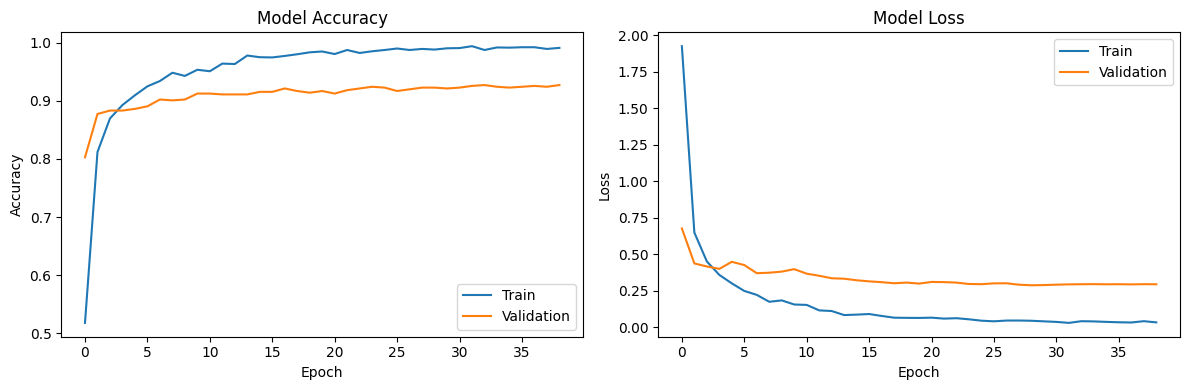

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import shutil
import patoolib

# Enable memory growth for GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

def extract_and_prepare_data(rar_path):
    """Extract RAR file and prepare data directory"""
    extract_path = '/content/extracted_animals'
    if os.path.exists(extract_path):
        shutil.rmtree(extract_path)
    os.makedirs(extract_path)

    patoolib.extract_archive(rar_path, outdir=extract_path)

    animals_dir = os.path.join(extract_path, 'animals')
    if not os.path.exists(animals_dir):
        animals_dir = extract_path

    class_folders = sorted(os.listdir(animals_dir))
    num_classes = len(class_folders)
    print(f"Found {num_classes} classes")

    # Print images per class
    for class_name in class_folders:
        class_path = os.path.join(animals_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"- {class_name}: {num_images} images")

    return animals_dir, num_classes

def create_model(num_classes):
    """Create and return the model"""
    # Load ResNet50 with pretrained weights
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Initially freeze all layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

def train_model():
    """Main training function"""
    data_dir, num_classes = extract_and_prepare_data('/content/drive/MyDrive/animals.rar')

    # Data augmentation
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    # Only preprocessing for validation
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )

    batch_size = 32

    train_ds = train_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',  # Changed to categorical
        subset='training',
        shuffle=True
    )

    val_ds = val_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',  # Changed to categorical
        subset='validation',
        shuffle=False
    )

    # Save class names
    class_names = list(train_ds.class_indices.keys())
    np.save('/content/drive/MyDrive/class_names.npy', class_names)

    # Create model
    model, base_model = create_model(num_classes)

    # Training strategy: First train only the top layers
    print("Phase 1: Training only top layers...")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train top layers
    history1 = model.fit(
        train_ds,
        epochs=10,
        validation_data=val_ds,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=5,
                restore_best_weights=True
            )
        ]
    )

    # Fine-tuning phase: Unfreeze some ResNet layers
    print("\nPhase 2: Fine-tuning ResNet layers...")
    for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tune with callbacks
    history2 = model.fit(
        train_ds,
        epochs=50,
        validation_data=val_ds,
        callbacks=[
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                '/content/drive/MyDrive/best_model.keras',
                save_best_only=True,
                monitor='val_accuracy'
            )
        ]
    )

    # Combine histories
    history = {}
    for k in history1.history.keys():
        history[k] = history1.history[k] + history2.history[k]

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/training_history.png')

    # Save final model
    model.save('/content/drive/MyDrive/DL_project.keras')

    # Final evaluation
    print("\nFinal evaluation:")
    final_loss, final_accuracy = model.evaluate(val_ds)
    print(f"Validation accuracy: {final_accuracy*100:.2f}%")
    print(f"Validation loss: {final_loss:.4f}")

    # Print classification report for a batch
    print("\nGenerating classification report for a batch...")
    x_val, y_val = next(val_ds)
    y_pred = model.predict(x_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Print some example predictions
    for i in range(min(5, len(y_pred_classes))):
        print(f"True: {class_names[y_true_classes[i]]} | Predicted: {class_names[y_pred_classes[i]]}")

if __name__ == "__main__":
    train_model()